In [30]:
import pandas as pd
from sklearn.datasets import load_iris, make_regression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import sympy as sp

In [31]:
# =========================
# Jeu de données de régression
# =========================
X, y = make_regression(
    n_samples=50,
    n_features=2,
    noise=10,
    random_state=42
)

# Mise en DataFrame
df_reg = pd.DataFrame(X, columns=["x1", "x2"])
df_reg["y"] = y

# Sauvegarde en CSV
df_reg.to_csv("jeu_regression.csv", index=False)

print("Jeu de données de régression sauvegardé sous 'jeu_regression_2vars.csv'")

Jeu de données de régression sauvegardé sous 'jeu_regression_2vars.csv'


In [32]:
# =========================
# Jeu de données de classification : Iris
# =========================
iris = load_iris(as_frame=True)
df_iris = iris.frame

# On garde uniquement 2 classes : Setosa (0) et Versicolor (1)
df_clf = df_iris[df_iris["target"].isin([0, 1])].copy()

# On ne garde que 2 attributs
df_clf = df_clf[["sepal length (cm)", "sepal width (cm)", "target"]]
df_clf.rename(columns={
    "sepal length (cm)": "x1",
    "sepal width (cm)": "x2",
    "target": "y"
}, inplace=True)

# Sauvegarde
df_clf.to_csv("jeu_classification.csv", index=False)
print("Jeu de données de classification sauvegardé sous 'jeu_classification_iris.csv'")

Jeu de données de classification sauvegardé sous 'jeu_classification_iris.csv'


In [33]:
# =========================
# Calcul Symbolique : définir variables
# =========================
y_sym, yhat_sym, delta_sym = sp.symbols('y yhat delta', real=True)
p1, p2 = sp.symbols('p1 p2', positive=True)
y1, y2 = sp.symbols('y1 y2')
r = sp.symbols('r', real=True)

In [34]:
# =========================
# Calcul Symbolique : définir les fonctions de perte
# =========================

L_mse = sp.Rational(1,2) * (y_sym - yhat_sym)**2
L_bce = - (y_sym*sp.log(yhat_sym) + (1-y_sym)*sp.log(1-yhat_sym))
L_cce = - (y1*sp.log(p1) + y2*sp.log(p2))
L_huber = sp.Piecewise((sp.Rational(1,2)*r**2, sp.Abs(r) <= delta_sym),
                       (delta_sym*(sp.Abs(r)-sp.Rational(1,2)*delta_sym), True))

# Gradients
grad_mse = sp.diff(L_mse, yhat_sym)
grad_bce = sp.diff(L_bce, yhat_sym)
grad_cce_p1 = sp.diff(L_cce, p1)
grad_cce_p2 = sp.diff(L_cce, p2)
grad_huber = sp.diff(L_huber, r)

print("Gradient MSE :", grad_mse)
print("Gradient BCE :", grad_bce)
print("Gradient CCE :", grad_cce_p1, grad_cce_p2)
print("Gradient Huber :", grad_huber)
print("\n--------------------------------\n")

# =========================
# Lambdify pour usage numérique
# =========================
mse_func = sp.lambdify((y_sym, yhat_sym), L_mse, "numpy")
bce_func = sp.lambdify((y_sym, yhat_sym), L_bce, "numpy")
cce_func = sp.lambdify((y1, y2, p1, p2), L_cce, "numpy")
huber_func = sp.lambdify((r, delta_sym), L_huber, "numpy")

Gradient MSE : -y + yhat
Gradient BCE : -y/yhat + (1 - y)/(1 - yhat)
Gradient CCE : -y1/p1 -y2/p2
Gradient Huber : Piecewise((r, delta >= Abs(r)), (delta*sign(r), True))

--------------------------------



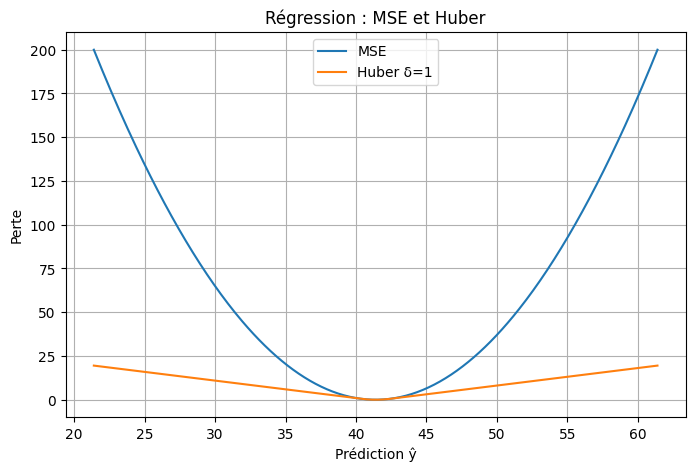

In [35]:
# =========================
# Surfaces pour la régression (MSE, Huber)
# =========================
y_true_example = float(df_reg["y"].iloc[0])
yhat_vals = np.linspace(y_true_example - 20, y_true_example + 20, 400)
mse_vals = mse_func(y_true_example, yhat_vals)
huber_vals = huber_func(y_true_example - yhat_vals, 1.0)

plt.figure(figsize=(8,5))
plt.plot(yhat_vals, mse_vals, label="MSE")
plt.plot(yhat_vals, huber_vals, label="Huber δ=1")
plt.title("Régression : MSE et Huber")
plt.xlabel("Prédiction ŷ")
plt.ylabel("Perte")
plt.legend()
plt.grid(True)
plt.show()

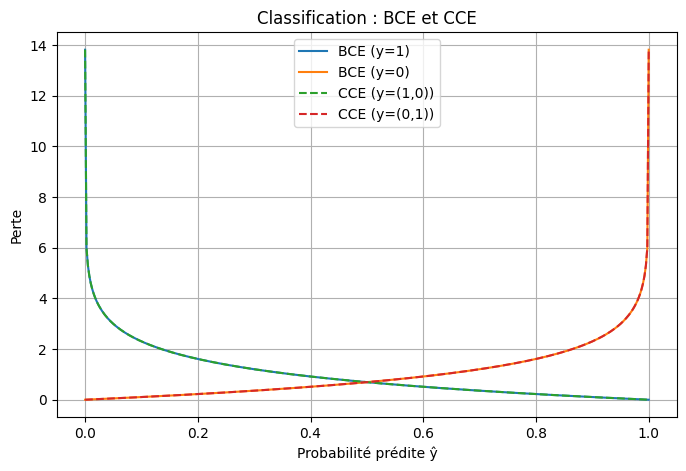

In [36]:
# =========================
# Surfaces pour la classification (BCE, CCE)
# =========================
yhat_probs = np.linspace(1e-6, 1-1e-6, 400)
bce_vals_pos = bce_func(1.0, yhat_probs)
bce_vals_neg = bce_func(0.0, yhat_probs)
cce_vals_pos = cce_func(1.0, 0.0, yhat_probs, 1 - yhat_probs)
cce_vals_neg = cce_func(0.0, 1.0, yhat_probs, 1 - yhat_probs)

plt.figure(figsize=(8,5))
plt.plot(yhat_probs, bce_vals_pos, label="BCE (y=1)")
plt.plot(yhat_probs, bce_vals_neg, label="BCE (y=0)")
plt.plot(yhat_probs, cce_vals_pos, "--", label="CCE (y=(1,0))")
plt.plot(yhat_probs, cce_vals_neg, "--", label="CCE (y=(0,1))")
plt.title("Classification : BCE et CCE")
plt.xlabel("Probabilité prédite ŷ")
plt.ylabel("Perte")
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# =========================
# Tangente à une ellipse
# =========================
y, yhat = sp.symbols("y yhat", real=True)

# Gradient
dL_dy = sp.diff(L_mse, y)
dL_dyhat = sp.diff(L_mse, yhat)

print("MSE :", L_mse)
print("Gradient :", (dL_dy, dL_dyhat))

# Exemple : tangente en un point donné (y0, yhat0)
y0_val, yhat0_val = 2.0, 1.0

# Equation de la tangente : grad(L)(y0,yhat0) • ([y,yhat] - [y0,yhat0]) = 0
A = dL_dy.subs({y:y0_val, yhat:yhat0_val})
B = dL_dyhat.subs({y:y0_val, yhat:yhat0_val})

y_sym, yhat_sym = sp.symbols("y_sym yhat_sym")
tangent_eq = sp.Eq(A*(y_sym - y0_val) + B*(yhat_sym - yhat0_val), 0)

print("Equation de la tangente :", tangent_eq)

MSE : (y - yhat)**2/2
Gradient : (y - yhat, -y + yhat)
Equation de la tangente : Eq(1.0*y_sym - 1.0*yhat_sym - 1.0, 0)
